# RNN Sentiment Classifier

In this notebook, we use an RNN to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import SimpleRNN # new! 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/rnn'

# training:
epochs = 16 # way more!
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# RNN layer architecture:
n_rnn = 256 
drop_rnn = 0.2

# dense layer architecture: 
# n_dense = 256
# dropout = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(SimpleRNN(n_rnn, dropout=drop_rnn))
# model.add(Dense(n_dense, activation='relu')) # typically don't see top dense layer in NLP like in 
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               82176     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 722,433
Trainable params: 722,433
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/16
25000/25000 [==============================] - 18s 709us/step - loss: 0.7023 - acc: 0.5132 - val_loss: 0.6993 - val_acc: 0.5311
Epoch 2/16
25000/25000 [==============================] - 17s 689us/step - loss: 0.6865 - acc: 0.5422 - val_loss: 0.6649 - val_acc: 0.5922
Epoch 3/16
25000/25000 [==============================] - 17s 682us/step - loss: 0.5905 - acc: 0.6776 - val_loss: 0.5816 - val_acc: 0.6835
Epoch 4/16
25000/25000 [==============================] - 17s 682us/step - loss: 0.5716 - acc: 0.6966 - val_loss: 0.5647 - val_acc: 0.7055
Epoch 5/16
25000/25000 [==============================] - 17s 680us/step - loss: 0.5848 - acc: 0.6982 - val_loss: 0.5329 - val_acc: 0.7458
Epoch 6/16
25000/25000 [==============================] - 17s 678us/step - loss: 0.5263 - acc: 0.7399 - val_loss: 0.6334 - val_acc: 0.6453
Epoch 7/16
25000/25000 [==============================] - 17s 681us/step - loss: 0.4484 - acc: 0.7962 - val_loss: 0.

#### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.07.hdf5") # zero-indexed

In [11]:
y_hat = model.predict_proba(x_valid)

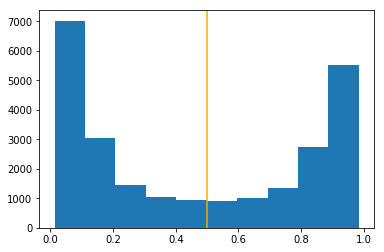

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'84.94'